In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
sys.path.append("..")

from xlstm_scaling_laws.model_accounting.memops.attention_op import count_memops_attention_generation
from xlstm_scaling_laws.model_accounting.memops.llama_backbone import count_memops_llama_backbone

import matplotlib.pyplot as plt

In [2]:
llama_160m = {
    "d_model": 512,
    "d_kv": 64,
    "d_ff": 2048,
    "num_heads": 12,
    "num_layers": 12,
    "vocab_size": 50304,
}

llama_1_4b = {
    "d_model": 2048,
    "d_kv": 128,
    "d_ff": 5632,
    "num_heads": 16,
    "num_layers": 24,
    "vocab_size": 50304
}

llama_7b = {
    "d_model": 4096,
    "d_kv": 128,
    "d_ff": 11008,
    "num_heads": 32,
    "num_layers": 32,
    "vocab_size": 50304
}

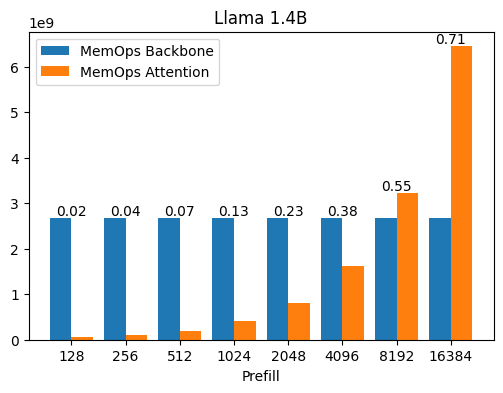

In [4]:
seq_lens = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
config = llama_1_4b

batch_size = 2
seq_len_gen = 1

plt.figure(figsize=(6, 4))

# calculate per 
for s, seq_len in enumerate(seq_lens):
    memops_backbone = count_memops_llama_backbone(
        batch_size=batch_size,
        seq_len=seq_len_gen,
        n_vocab=config["vocab_size"],
        n_blocks=config["num_layers"],
        d_ff=config["d_ff"],
        n_headq=config["num_heads"],
        n_headkv=config["num_heads"],
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        bytes_act=2,
        bytes_w=2,
        with_unembed=True
    ) / seq_len_gen

    memops_attn = config["num_layers"] * count_memops_attention_generation(
        batch_size=batch_size,
        seq_len_pre=seq_len,
        seq_len_gen=seq_len_gen,
        d_qk=config["d_kv"],
        d_hv=config["d_kv"],
        n_headq=config["num_heads"],
        n_headkv=config["num_heads"],
        bytes_act=2
    ) / seq_len_gen

    plt.bar(s-0.2, memops_backbone, label="MemOps Backbone" if s == 0 else "", color="C0", width=0.4)
    plt.bar(s+0.2, memops_attn, label="MemOps Attention" if s == 0 else "", color="C1", width=0.4)
    # text with ratio on top of bars
    plt.text(s, max(memops_backbone, memops_attn) , f"{memops_attn / (memops_attn + memops_backbone):.2f}", ha="center", va="bottom")
    # axs[1].set_yscale("log")
    plt.xticks(ticks=np.arange(len(seq_lens)), labels=seq_lens)
    plt.xlabel("Prefill")
    plt.legend()
plt.title("Llama 1.4B")
plt.show()
